<a href="https://colab.research.google.com/github/Norceis/radar-project/blob/main/radar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, concatenate, Activation, Concatenate, Conv2DTranspose, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

In [2]:
with open('data_slices_mulitchannel_6.pickle', 'rb') as f:
    x, y = pickle.load(f)

classes = [
            'BARTEK',
            'KUBA',
            'OSKAR',
            'RAFAL'
]

print(x.shape, y.shape)

# skip classes 0 and 4
x = x[np.where(y != 5)]
y = y[np.where(y != 5)]

x = x[np.where(y != 4)]
y = y[np.where(y != 4)]

print(x.shape, y.shape)

y = to_categorical(y, num_classes=len(classes))

print(x.shape, y.shape)

img_shape = x[0].shape

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

(8184, 54, 216, 7) (8184,)
(5536, 54, 216, 7) (5536,)
(5536, 54, 216, 7) (5536, 4)


In [18]:
model = Sequential()

model.add(Conv2D(16, (3,3), padding='same', input_shape=img_shape))
model.add(MaxPooling2D())
model.add(LeakyReLU())
model.add(Dropout(0.3))

for k in [32, 64, 128, 256 ]:
      model.add(Conv2D(k, (3,3), padding='same'))
      model.add(MaxPooling2D())
      model.add(LeakyReLU())
      model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512))
model.add(LeakyReLU())
model.add(Dropout(0.3))
model.add(Dense(len(classes), activation='softmax'))
model.summary()

slice = Input(shape=img_shape)
pred = model(slice)
radar_model = Model(slice, pred)


METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy')
]

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)

# optimizer = Adam(0.0002, 0.5)
radar_model.compile(loss='categorical_crossentropy',
                          optimizer='Adam',
                        metrics=METRICS)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 54, 216, 16)       1024      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 27, 108, 16)      0         
 g2D)                                                            
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 27, 108, 16)       0         
                                                                 
 dropout_33 (Dropout)        (None, 27, 108, 16)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 27, 108, 32)       4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 13, 54, 32)       0         
 g2D)                                                 

In [19]:
history = radar_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=100, callbacks=[early_callback])

Epoch 1/100
139/139 [==============================] - 32s 210ms/step - loss: 1.3833 - accuracy: 0.7496 - val_loss: 1.3623 - val_accuracy: 0.7500
Epoch 2/100
139/139 [==============================] - 27s 197ms/step - loss: 1.3427 - accuracy: 0.7519 - val_loss: 1.3364 - val_accuracy: 0.7505
Epoch 3/100
139/139 [==============================] - 28s 201ms/step - loss: 1.3029 - accuracy: 0.7547 - val_loss: 1.2767 - val_accuracy: 0.7556
Epoch 4/100
139/139 [==============================] - 26s 190ms/step - loss: 1.2599 - accuracy: 0.7608 - val_loss: 1.2596 - val_accuracy: 0.7581
Epoch 5/100
139/139 [==============================] - 26s 188ms/step - loss: 1.2159 - accuracy: 0.7658 - val_loss: 1.2383 - val_accuracy: 0.7640
Epoch 6/100
139/139 [==============================] - 27s 191ms/step - loss: 1.1697 - accuracy: 0.7765 - val_loss: 1.1848 - val_accuracy: 0.7717
Epoch 7/100
139/139 [==============================] - 27s 192ms/step - loss: 1.1037 - accuracy: 0.7864 - val_loss: 1.2188 -

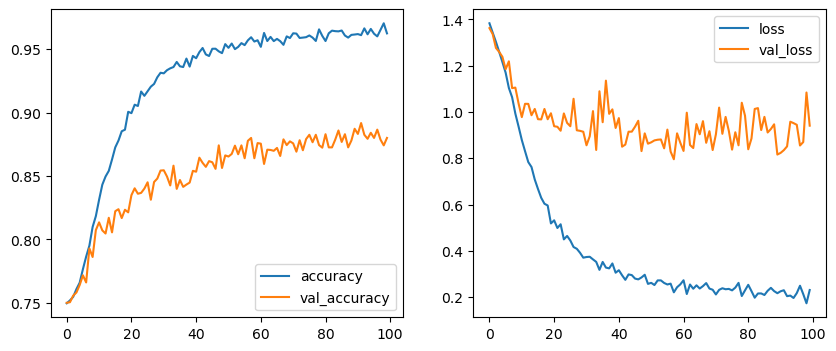

In [20]:
import matplotlib.pyplot as plt
# Plot accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].legend(['accuracy', 'val_accuracy'])

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss', 'val_loss'])
plt.show()

In [21]:
radar_model.evaluate(x_test, y_test)


35/35 [==============================] - 2s 52ms/step - loss: 0.9407 - accuracy: 0.8800


[0.9407472014427185, 0.8799638748168945]

In [8]:
np.unique(y, return_counts=True)

(array([0., 1.], dtype=float32), array([42065,  8413], dtype=int64))

35/35 [==============================] - 1s 39ms/step


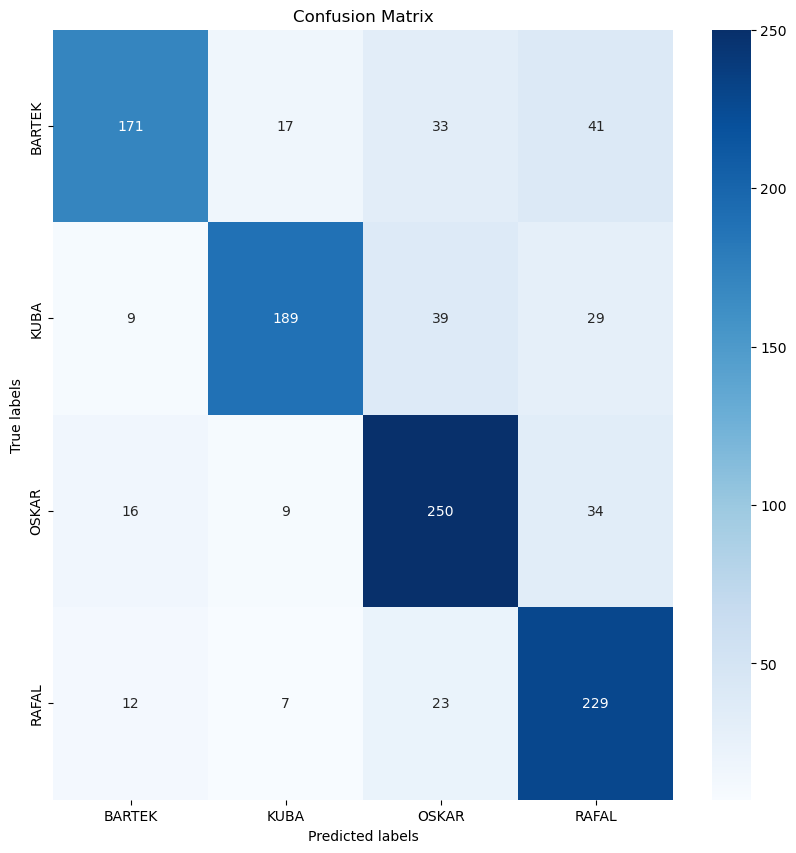

In [26]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = radar_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues',fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)
plt.show()

In [27]:
# save model
radar_model.save('radar_model.h5')
